In [303]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import pandas as pd
import heapq
import copy

In [304]:
class Node:
    def __init__(self, x, y, parent=None):
        self.x = x # x and y coordinates on the map for the node
        self.y = y
        self.neighbors = [] # list of conections to other nodes
        self.g = 0 # cost of getting to the node from the start 
        self.h = 0 # heuristic value for the node
        self.f = 0 # addition of the g and h values
        self.parent = parent # where does this node comes from 

    def add_neighbor(self, neighbor):
        self.neighbors.append(neighbor) # add a neighbor to the node

    def get_coordinates(self):
        return self.x, self.y # return the x and y coordinates of the node
    
    def __lt__(self, other):
        return self.f < other.f # compare the f values of the nodes
    
    def __repr__(self):
        # return the coordinates of the node
        return f"Node({self.x}, {self.y})" 
    
    def calculate_h(self, goal):
        # calculate the heuristic value of the node
        self.h = np.sqrt((self.x - goal.x)**2 + (self.y - goal.y)**2)
        self.f = self.g + self.h # update the f value of the node


## Graph environment 

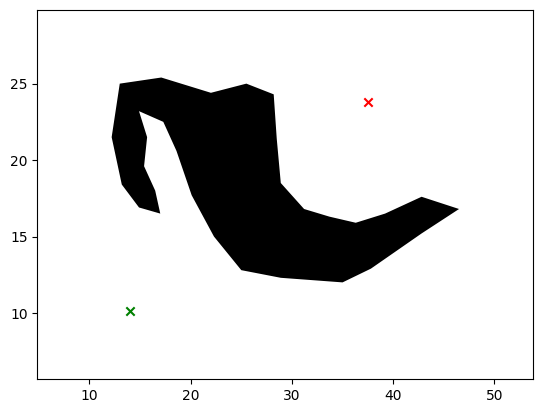

[Node(14.0, 10.1), Node(17.0, 16.5), Node(14.9, 16.9), Node(13.2, 18.4), Node(12.2, 21.5), Node(13.0, 25.0), Node(17.1, 25.4), Node(22.0, 24.4), Node(25.5, 25.0), Node(28.2, 24.3), Node(28.5, 21.4), Node(28.9, 18.5), Node(31.2, 16.8), Node(33.7, 16.3), Node(36.3, 15.9), Node(39.2, 16.5), Node(42.8, 17.6), Node(46.5, 16.8), Node(42.8, 15.2), Node(37.8, 12.9), Node(35.0, 12.0), Node(28.9, 12.3), Node(25.0, 12.8), Node(22.3, 15.0), Node(20.1, 17.7), Node(18.6, 20.6), Node(17.3, 22.5), Node(14.9, 23.2), Node(15.7, 21.5), Node(15.4, 19.6), Node(16.5, 18.0), Node(37.5, 23.8)]


In [305]:
env = "mx" # select the environment to be used 
vertices = pd.read_csv("env_"+env+".csv") # read the csv file with the vertices of the environment

first_column_data = vertices[vertices.columns[0]] # get the first column of the csv file

a = [] # list to store the vertices of the polygons
polygons = [] # list to store the polygons
nodes = [] # list to store the nodes
pol_number = 0
node_number = 0

# get the x and y coordinates of the start
xs, ys = vertices[vertices.columns[1]][0], vertices[vertices.columns[2]][0] 

for i in range (len(first_column_data)):
    # get the x and y coordinates of the vertices
    x,y = vertices[vertices.columns[1]][i], vertices[vertices.columns[2]][i] 
    nodes.append(Node(x,y)) # create a node with the x and y coordinates
    if pol_number != vertices[vertices.columns[0]][i]:
        polygons.append(a) # add the vertices to the polygons list
        pol_number = vertices[vertices.columns[0]][i]
        a = []
    a.append([x,y])

goal = Node(x,y) # get the x and y coordinates of the goal

fig,ax = plt.subplots()

for i in range(1, len(polygons)):
    # plot the polygons
    ax.add_patch(matplotlib.patches.Polygon(polygons[i], facecolor = 'k'))

# fix the limits of the plot
min_x = min(vertices[vertices.columns[1]])
max_x = max(vertices[vertices.columns[1]])
min_y = min(vertices[vertices.columns[2]])
max_y = max(vertices[vertices.columns[2]])
mean_x = (min_x + max_x)/8
mean_y = (min_y + max_y)/8
ax.set_xlim([min_x - mean_x, max_x + mean_x])
ax.set_ylim([min_y - mean_y, max_y + mean_y])

# plot the start and goal
ax.scatter(xs,ys, marker = "x", c="g")
ax.scatter(goal.x,goal.y, marker = "x", c="r")

plt.show()

print (nodes)


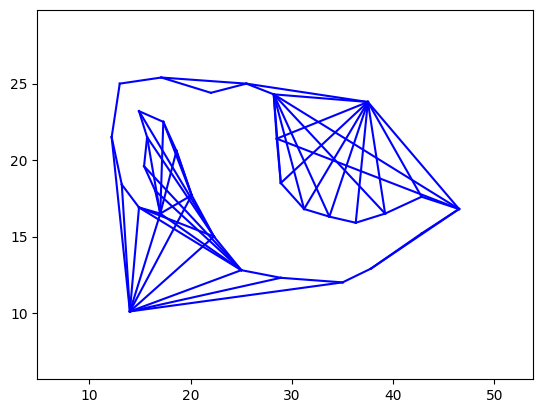

In [306]:
lines = pd.read_csv("visibility_graph_env_"+env+".csv")
connections = []
fig,ax = plt.subplots()
# plot the connections between the nodes
for i in range (len(lines[lines.columns[0]])):
    # get the x and y coordinates of the nodes
    x1,y1 = lines[lines.columns[0]][i], lines[lines.columns[1]][i] 
    # get the nodes that are connected
    nodes[x1].add_neighbor(nodes[y1])
    nodes[y1].add_neighbor(nodes[x1])
    # plot the connections
    connectionsx = [vertices[vertices.columns[1]][x1], vertices[vertices.columns[1]][y1]]
    connectionsy = [vertices[vertices.columns[2]][x1], vertices[vertices.columns[2]][y1]]
    plt.plot(connectionsx, connectionsy, c = 'b')

ax.set_xlim([min_x - mean_x, max_x + mean_x])
ax.set_ylim([min_y - mean_y, max_y + mean_y])
plt.show()

In [307]:
# 
for i in nodes:
    i.calculate_h(goal)
print (nodes)

[Node(14.0, 10.1), Node(17.0, 16.5), Node(14.9, 16.9), Node(13.2, 18.4), Node(12.2, 21.5), Node(13.0, 25.0), Node(17.1, 25.4), Node(22.0, 24.4), Node(25.5, 25.0), Node(28.2, 24.3), Node(28.5, 21.4), Node(28.9, 18.5), Node(31.2, 16.8), Node(33.7, 16.3), Node(36.3, 15.9), Node(39.2, 16.5), Node(42.8, 17.6), Node(46.5, 16.8), Node(42.8, 15.2), Node(37.8, 12.9), Node(35.0, 12.0), Node(28.9, 12.3), Node(25.0, 12.8), Node(22.3, 15.0), Node(20.1, 17.7), Node(18.6, 20.6), Node(17.3, 22.5), Node(14.9, 23.2), Node(15.7, 21.5), Node(15.4, 19.6), Node(16.5, 18.0), Node(37.5, 23.8)]


In [308]:
def a_star_conti(nodes, cost="euclidean"):

    # A* algorithm for continuous environments
    open_list = []
    closed_list = []
    start = nodes[0]
    start.f = start.h # set the f value of the start node
    goal = nodes[-1] # get the goal node
    open_list.append(start) # add the start node to the open list

    while open_list:
        current_node = open_list[0]
        for node in open_list:
            # get the node with the lowest f value
            if node.f < current_node.f:
                current_node = node

        # remove the current node from the open list and add it to the closed list
        open_list.remove(current_node)
        closed_list.append(current_node)

        # check if the current node is the goal node
        if current_node == goal:
            path = []
            while current_node:
                path.append(current_node)
                current_node = current_node.parent
            return path[::-1]
        
        # check the neighbors of the current node
        for neighbor in current_node.neighbors:
            if neighbor in closed_list:
                # if the neighbor is in the closed list, skip it
                continue
            if neighbor not in open_list:
                open_list.append(neighbor) # add the neighbor to the open list
                neighbor.parent = current_node # set the parent of the neighbor
                if cost == "euclidean":
                    neighbor.g = current_node.g + np.sqrt((neighbor.x - current_node.x)**2+(neighbor.y - current_node.y)**2)
                else:
                    neighbor.g = current_node.g + 1
                neighbor.f = neighbor.g + neighbor.h # set the f value of the neighbor
            else:
                if cost == "euclidean":
                    if neighbor.g > current_node.g + np.sqrt((neighbor.x - current_node.x)**2+(neighbor.y - current_node.y)**2):
                        neighbor.g = current_node.g+ np.sqrt((neighbor.x - current_node.x)**2+(neighbor.y - current_node.y)**2)
                        neighbor.f = neighbor.g + neighbor.h
                        neighbor.parent = current_node
                else:
                    if neighbor.g > current_node.g + 1:
                        neighbor.g = current_node.g + 1
                        neighbor.f = neighbor.g + neighbor.h
                        neighbor.parent = current_node
    return None

In [309]:
# get the path from the start to the goal
a_star_path = a_star_conti(nodes, cost="euclidean")
print(a_star_path)

[Node(14.0, 10.1), Node(12.2, 21.5), Node(13.0, 25.0), Node(17.1, 25.4), Node(25.5, 25.0), Node(37.5, 23.8)]


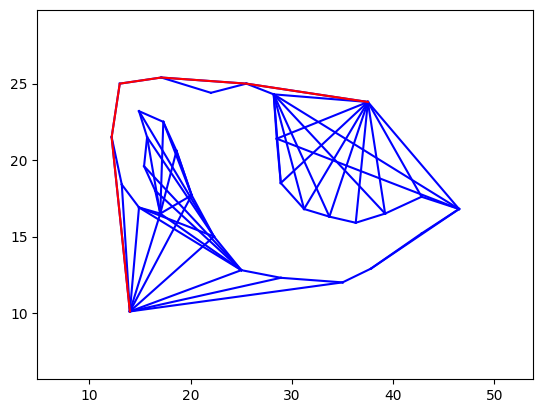

In [310]:
lines = pd.read_csv("visibility_graph_env_"+env+".csv")
connections = []

fig,ax = plt.subplots()
# plot the connections between the nodes
for i in range (len(lines[lines.columns[0]])):
    # get the x and y coordinates of the nodes
    x1,y1 = lines[lines.columns[0]][i], lines[lines.columns[1]][i] 
    # plot the connections
    connectionsx = [vertices[vertices.columns[1]][x1], vertices[vertices.columns[1]][y1]]
    connectionsy = [vertices[vertices.columns[2]][x1], vertices[vertices.columns[2]][y1]]
    plt.plot(connectionsx, connectionsy, c = 'b')

# plot the path from the start to the goal
path_x = []
path_y = []
for i in range (len(a_star_path)):
    x1,y1 = a_star_path[i].x, a_star_path[i].y
    path_x.append(x1)
    path_y.append(y1)
ax.set_xlim([min_x - mean_x, max_x + mean_x])
ax.set_ylim([min_y - mean_y, max_y + mean_y])
plt.plot(path_x, path_y, c = 'r')
plt.show()

## GIRD MAPS 


In [311]:
def find_neighbours(position, map, neighbours_num=4):
    # Extract dimensions of the map
    height, width = map.shape
    y, x = position  # Unpack the position
    neighbours = []  # Initialize an empty list for neighbors

    # Define the relative positions for 4-connectivity and 8-connectivity
    directions_4 = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    directions_8 =[(-1,-1),(0,-1),(1,-1),(-1,0),(1,0),(-1,1),(0,1),(1,1)]
    # Choose directions based on the connectivity required
    directions = directions_4 if neighbours_num == 4 else directions_8

    # Loop through each direction and check if it's valid
    for dy, dx in directions:
        ny, nx = y + dy, x + dx  # Calculate the neighbor's position
        # Check if the neighbor is within bounds and is 0
        if 0 <= ny < height and 0 <= nx < width and map[ny, nx] == 0:
            neighbours.append((ny, nx))  # Add valid neighbor

    return neighbours

def calculate_h(p,goal):
    return np.sqrt((p[0] - goal[0])**2 + (p[1] - goal[1])**2)
    # f = g + h # update the f value of the node)
 
def reconstruct_path(cameFrom, current):
    total_path = [current]
    while current in cameFrom:
        current = cameFrom[current]
        total_path.append(current)
    return total_path[::-1]


Cost for map 0 with 4-neighbours: 154.00


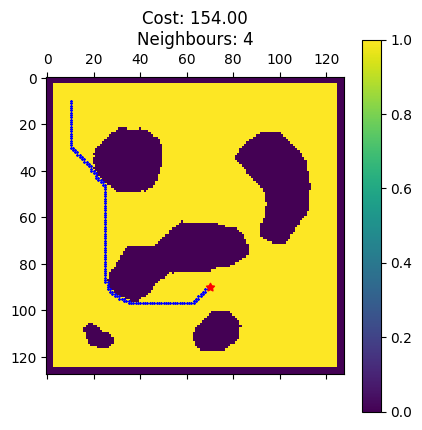

Cost for map 0 with 8-neighbours: 133.58


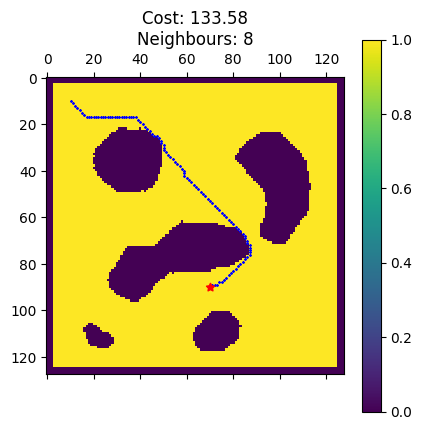

Cost for map 1 with 4-neighbours: 240.00


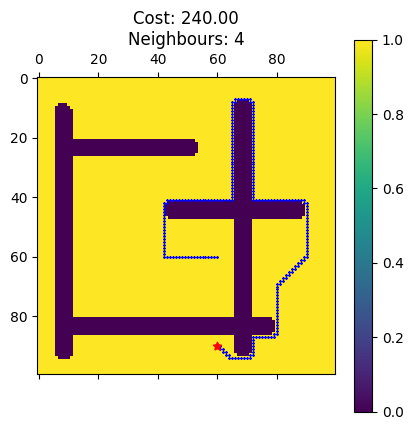

Cost for map 1 with 8-neighbours: 191.97


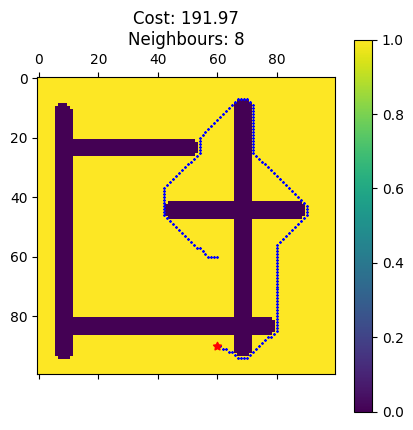

Cost for map 2 with 4-neighbours: 632.00


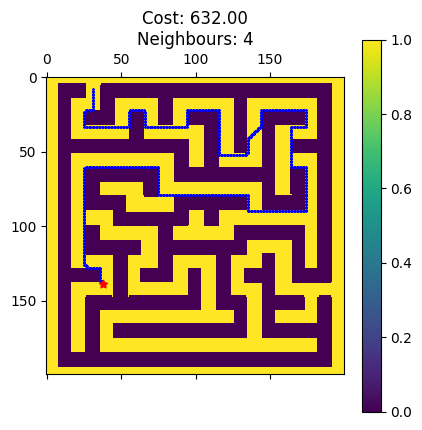

Cost for map 2 with 8-neighbours: 555.85


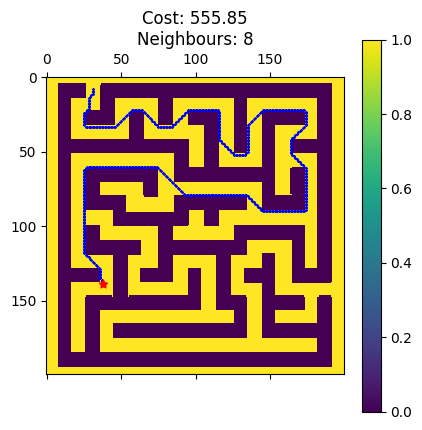

Cost for map 3 with 4-neighbours: 688.00


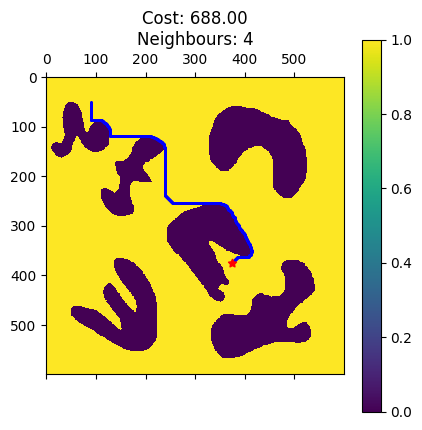

Cost for map 3 with 8-neighbours: 523.39


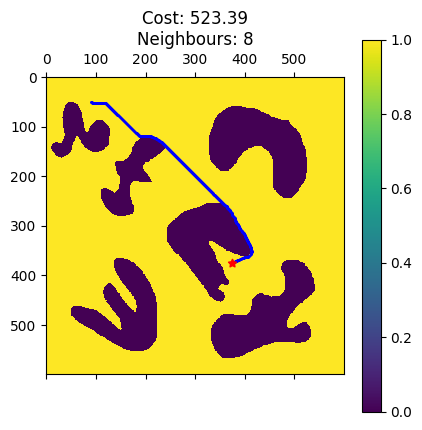

In [312]:

def a_star(map, start, goal, num_neigh):
    g_map = np.full(map.shape, np.inf)
    f_map = np.full(map.shape, np.inf)
    open_set = []
    cameFrom = {}
    g_map[start] = 0
    f_map[start] = calculate_h(start, goal)
    heapq.heappush(open_set, (f_map[start], start))
    
    while open_set:
        current = heapq.heappop(open_set)[1]
        if current == tuple(goal):
            return reconstruct_path(cameFrom, current), g_map[goal[0],goal[1]]
        
        neighbours = find_neighbours(current, map, num_neigh)
        for neighbour in neighbours:
            tentative_gScore = g_map[current[0],current[1]] + calculate_h(current, neighbour)
            if tentative_gScore < g_map[neighbour]:
                cameFrom[neighbour] = tuple(current)
                g_map[neighbour] = tentative_gScore
                f_map[neighbour] = g_map[neighbour] + calculate_h(neighbour, goal)
                if all(neighbour != item[1] for item in open_set):
                    heapq.heappush(open_set, (f_map[neighbour], neighbour))
    
    return None, np.inf


for map_n in range(0, 4):  # Includes map 0, 1, 2, and 3
    map_number = map_n

    # Assign goal and start coordinates for each map
    if map_number == 0: 
        goal = (90, 70)
        start = (10, 10)
    elif map_number == 1:
        goal = (90, 60)
        start = (60, 60)
    elif map_number == 2:
        goal = (139, 38)
        start = (8, 31)
    elif map_number == 3:
        goal = (375, 375)
        start = (50, 90)
    else:
        goal = (30, 30)
        start = (1, 1)

    # Load grid map
    try:
        image = Image.open(f'map{map_number}.png').convert('L')
    except FileNotFoundError:
        print(f"Map file 'map{map_number}.png' not found. Skipping...")
        continue

    grid_map = np.array(image.getdata()).reshape(image.size[0], image.size[1]) / 255
    # Binarize the image
    grid_map[grid_map > 0.5] = 1
    grid_map[grid_map <= 0.5] = 0
    # Invert colors to make 0 -> free and 1 -> occupied
    grid = (grid_map * -1) + 1

    for n in [4, 8]:  # Neighbours
        path, cost = a_star(grid, start, goal, num_neigh=n)
        
        if path is None:
            print(f"No path found for map {map_number} with {n}-neighbours.")
            continue

        print(f"Cost for map {map_number} with {n}-neighbours: {cost:.2f}")

        # Extract x and y values from the path
        x_values = list(zip(*path))[0]
        y_values = list(zip(*path))[1]

        # Plot the map
        plt.matshow(grid_map, origin='upper')
        plt.colorbar()

        # Plot the path
        plt.scatter(y_values, x_values, s=1, marker="*", c="b")

        # Mark the goal
        plt.scatter(goal[1], goal[0], c="r", marker=(5, 1))

        # Add cost text to the plot
        plt.title(f"Cost: {cost:.2f}\nNeighbours: {n}")

        # Show the plot
        plt.show()
